In [2]:
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool
from kaggle_hm.chart_model import filter_data
from copy import deepcopy
import numpy as np
import os
import seaborn as sns
import pandas as pd
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.evaluation import compute_precision
import kaggle_hm.als_model
from kaggle_hm.chart_model import age_chart
from kaggle_hm.evaluation import plot_precision_at_k, enrich_data, precision_by_age, precision_by_usage
from kaggle_hm import ranking_features as rf
from sklearn.model_selection import train_test_split
from importlib import reload

In [24]:
rf = reload(kaggle_hm.ranking_features)

In [2]:
candidates = pd.read_parquet(data_root / '2020-09-08' / 'X.parquet')

In [3]:
candidates.head()

,score,customer_id,article_id,method,product_code,article_totals,product_totals,age,product_type_name,colour_group_name,...,item_age,daily_sales,monday_item,avg_per_customer,segment,total_items,product_type_name_clean,colour_group_name_clean,department_name_clean,section_name_clean
0,0.015371,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0573937001,als,573937,NaN,NaN,28.0,Trousers,Black,...,0.032258,3.592593,0,1.328767,old,11,0.222222,0.500000,0.166667,0.388889
1,0.014880,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0931769003,als,931769,NaN,NaN,28.0,Trousers,Dark Grey,...,0.083333,25.250000,0,1.278481,old,11,0.222222,0.111111,0.166667,0.388889
2,0.011691,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0881244001,als,881244,NaN,NaN,28.0,Trousers,Black,...,0.032258,13.709677,0,1.388889,old,11,0.222222,0.500000,0.111111,0.111111
3,0.010719,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0698387001,als,698387,NaN,NaN,28.0,Trousers,Black,...,0.033333,2.750000,1,1.404255,old,11,0.222222,0.500000,0.111111,0.111111
4,0.009584,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0889652001,als,889652,NaN,NaN,28.0,Trousers,Black,...,0.032258,10.538462,0,1.256881,old,11,0.222222,0.500000,0.166667,0.388889


In [5]:
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
test = filter_data(df, from_date=test_dates['start'], to_date=test_dates['end'])
results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()

In [6]:
candidates = candidates[candidates['customer_id'].isin(test['customer_id'].unique())]

In [8]:
test_nodup = test.drop_duplicates(subset=['customer_id', 'article_id'])[['customer_id', 'article_id', 'price']]
candidates = candidates.merge(test_nodup[['customer_id', 'article_id', 'price']], on=['customer_id', 'article_id'], how='left')
candidates['is_relevant'] = candidates['price'].notna().astype('int')

In [9]:
candidates['customer_id'].nunique()

64841

In [27]:
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])
train = filter_data(df, from_date='2020-09-01', to_date=train_dates['end'])
t_cust = set(train['customer_id'].unique())
full_ds = filter_data(df, to_date=train_dates['end'])
old_cust = set(full_ds['customer_id'].unique()) - t_cust
cold_cust = set(test['customer_id'].unique()) - old_cust - t_cust

In [10]:
cols = [f'rel_{i + 1}' for i in range(12)]

In [11]:
features = [
    'score',
    'article_totals',
    'age',
    'product_type_name_clean',
    'colour_group_name_clean',
    'department_name_clean',
    'section_name_clean',
    'total_cust',
    'item_age',
    'monday_item',
    'avg_per_customer',
    'daily_sales',
    'avg_price',
    'avg_age',
    'product_totals',
    'segment',
    'method'
]

In [12]:
rel_stats = candidates.groupby('customer_id').agg(relevant=('is_relevant', 'sum'))
rel_stats['relevant'].value_counts().sort_index()

0     54445
1      8038
2      1761
3       428
4       116
5        33
6         9
7         7
8         1
9         1
10        1
11        1
Name: relevant, dtype: int64

In [13]:
train_customers, test_customers = train_test_split(test['customer_id'].unique(), test_size=0.2, random_state=42)

train_df = candidates[candidates['customer_id'].isin(train_customers)].copy()
test_df = candidates[candidates['customer_id'].isin(test_customers)].copy()

X_train = train_df[features]
y_train = train_df['is_relevant']
queries_train = train_df['customer_id']

X_test = test_df[features]
y_test = test_df['is_relevant']
queries_test = test_df['customer_id']

train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
    cat_features=['segment', 'method']
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test,
    cat_features=['segment', 'method']
)

In [34]:
candidates[candidates['customer_id'].isin(train_customers)]['customer_id'].nunique() / len(train_customers)

0.9075935086349041

In [25]:
candidates[candidates['customer_id'].isin(test_customers)]['customer_id'].nunique() / len(test_customers)

0.9088447653429603

In [14]:
default_parameters = {
    'iterations': 2000,
    'custom_metric': ['MAP:top=10', 'NDCG'],
    'verbose': True,
    'metric_period': 200,
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 0,
    'learning_rate': 0.01,
    'one_hot_max_size': 10
}

parameters = {}

def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=test_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)

    return model

In [15]:
X_train.count()

score                      1245360
article_totals               81003
age                        1245360
product_type_name_clean    1245360
colour_group_name_clean    1245360
department_name_clean      1245360
section_name_clean         1245360
total_cust                 1245360
item_age                   1245360
monday_item                1245360
avg_per_customer           1245360
daily_sales                1245360
avg_price                  1245360
avg_age                    1245360
product_totals              161838
segment                    1245360
method                     1245360
dtype: int64

In [16]:
train_pool.get_feature_names()

['score',
 'article_totals',
 'age',
 'product_type_name_clean',
 'colour_group_name_clean',
 'department_name_clean',
 'section_name_clean',
 'total_cust',
 'item_age',
 'monday_item',
 'avg_per_customer',
 'daily_sales',
 'avg_price',
 'avg_age',
 'product_totals',
 'segment',
 'method']

In [17]:
train_df.pivot_table(index='method', columns='is_relevant', values='article_id', aggfunc='count')

is_relevant,0,1
method,,
als,1234496,10864


In [18]:
test_df.pivot_table(index='method', columns='is_relevant', values='article_id', aggfunc='count')

is_relevant,0,1
method,,
als,308074,2750


In [19]:
model = fit_model('PairLogit')

Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6899811	test: 0.6900737	best: 0.6900737 (0)	total: 86.9ms	remaining: 2m 53s
200:	learn: 0.5333316	test: 0.5409598	best: 0.5409598 (200)	total: 2.23s	remaining: 19.9s
400:	learn: 0.5095955	test: 0.5245618	best: 0.5245618 (400)	total: 4.24s	remaining: 16.9s
600:	learn: 0.4963163	test: 0.5178791	best: 0.5178791 (600)	total: 6.17s	remaining: 14.4s
800:	learn: 0.4864915	test: 0.5143854	best: 0.5143854 (800)	total: 8.22s	remaining: 12.3s
1000:	learn: 0.4782111	test: 0.5124841	best: 0.5124841 (1000)	total: 10.3s	remaining: 10.2s
1200:	learn: 0.4706748	test: 0.5108093	best: 0.5108093 (1200)	total: 12.4s	remaining: 8.23s
1400:	learn: 0.4638505	test: 0.5096789	best: 0.5096789 (1400)	total: 14.5s	remaining: 6.2s
1600:	learn: 0.4576930	test: 0.5089910	best: 0.5089910 (1600)	total: 16.6s	remaining: 4.13s
1800:	learn: 0.4517231	test: 0.5082374	best: 0.5082374 (1800)	total: 18.6s	remaining: 2.06s
1999:	learn: 0.4459425	test: 0.5077790	best: 0.5077790 (1999)	total: 20.7s	remaining: 0us
bes

In [20]:
model.save_model(data_root / '2020-09-08' / 'pair_logit.model')

In [21]:
model.get_best_score()

{'learn': {'MAP:top=10': 0.06543607968622309, 'PairLogit': 0.445942523705813},
 'validation': {'NDCG:type=Base': 0.924467643603086,
  'MAP:top=10': 0.05813643420374012,
  'PairLogit': 0.5077789866058346}}

In [22]:
model.feature_names_

['score',
 'article_totals',
 'age',
 'product_type_name_clean',
 'colour_group_name_clean',
 'department_name_clean',
 'section_name_clean',
 'total_cust',
 'item_age',
 'monday_item',
 'avg_per_customer',
 'daily_sales',
 'avg_price',
 'avg_age',
 'product_totals',
 'segment',
 'method']

In [23]:
fe = model.get_feature_importance(test_pool, type='LossFunctionChange')

In [24]:
pd.DataFrame({
    'score': fe,
    'name': model.feature_names_
}).sort_values('score', ascending=False)

,score,name
0,0.033676,score
14,0.020756,product_totals
1,0.006341,article_totals
11,0.005649,daily_sales
15,0.003854,segment
12,0.003836,avg_price
4,0.002799,colour_group_name_clean
8,0.002504,item_age
13,0.001848,avg_age
7,0.001746,total_cust


In [25]:
rec_df = rf.rank_predictions(test_df, model)
comb = results.merge(rec_df, on='customer_id')
comb = comb[comb['candidates'].str.len() > 1]
comb['prediction'] = comb['candidates']
comb = compute_precision(comb)
comb['precision'].mean()

0.034902760601560674

In [28]:
comb_enriched = enrich_data(filter_data(df, to_date='2020-09-08'), comb.set_index('customer_id'), c.set_index('customer_id'))

In [29]:
comb['segment'] = 'old'
comb.loc[comb['customer_id'].isin(t_cust), 'segment'] = 'train'

In [30]:
comb.groupby('segment').agg(
    customers=('customer_id', 'count'),
    avg_precision=('precision', 'mean'),
)

,customers,avg_precision
segment,,
old,9879,0.021349
train,3072,0.078489


In [31]:
N = len(test_customers)

(9992 / N * .0213 + 3099 / N * 0.078 + 1313/ N * 0.008)

0.03228655928908636

In [32]:
test_df['prediction_rank'] = test_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')
test_df['score_rank'] = test_df.groupby('customer_id')['score'].rank(ascending=False, method='first')

<AxesSubplot:xlabel='prediction_rank'>

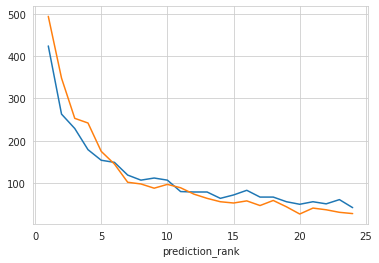

In [33]:
test_df.groupby('score_rank')['is_relevant'].agg(['mean', 'sum']).reset_index().set_index('score_rank')['sum'].plot()
test_df.groupby('prediction_rank')['is_relevant'].agg(['mean', 'sum']).reset_index().set_index('prediction_rank')['sum'].plot()

In [34]:
from catboost.utils import eval_metric

eval_metric(y_test.values, test_df['prediction'].values, 'MAP:top=12', group_id=queries_test.values)

[0.05918699463002444]

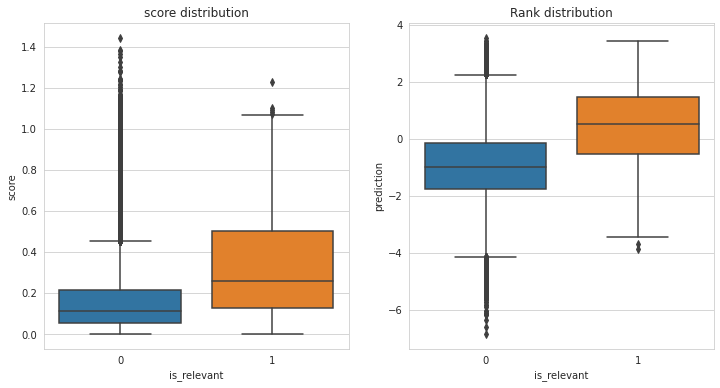

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(data=test_df.query('method == "als"'), x='is_relevant', y='score', ax=ax[0])
ax[0].set_title('score distribution')

sns.boxplot(data=test_df, x='is_relevant', y='prediction', ax=ax[1])
plt.title('Rank distribution');

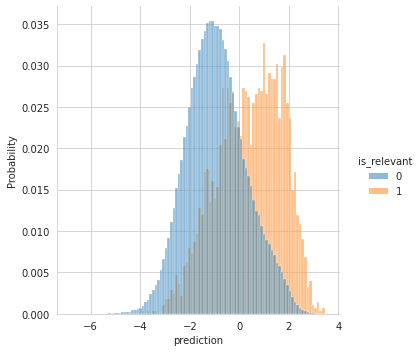

In [36]:
sns.displot(data=test_df, x='prediction', hue='is_relevant', stat='probability', common_norm=False, bins=100)

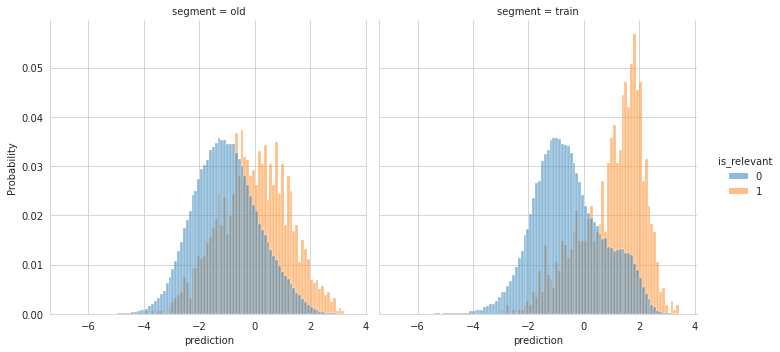

In [37]:
sns.displot(data=test_df, x='prediction', hue='is_relevant', col='segment', stat='probability', common_norm=False, bins=100);

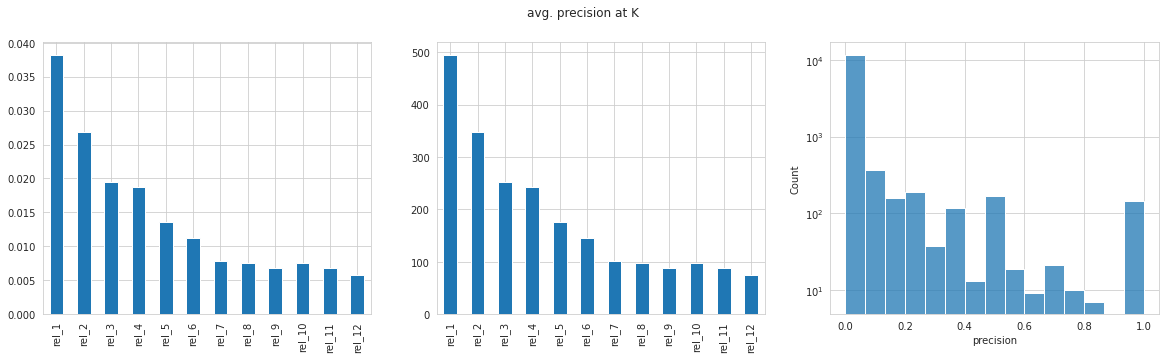

In [38]:
plot_precision_at_k(comb);

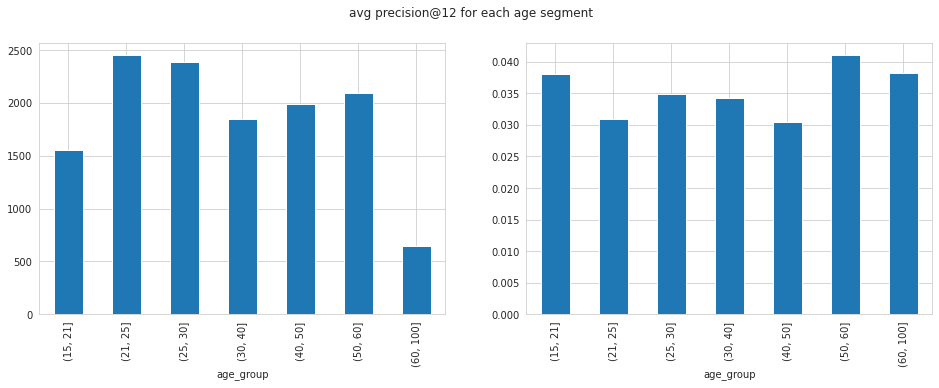

In [39]:
precision_by_age(comb_enriched);

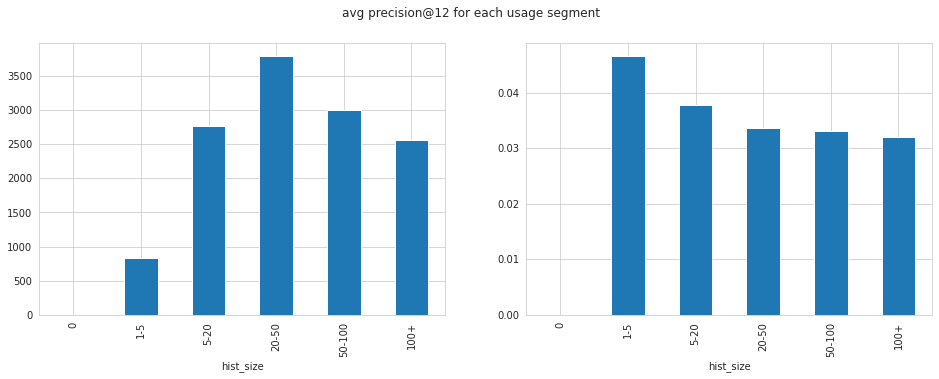

In [40]:
precision_by_usage(comb_enriched);

In [41]:
stats = (
    test_df
    .groupby('customer_id')
    .agg(
        total=('article_id', 'count'),
        hits=('is_relevant', 'sum'),
        has_hit=('is_relevant', 'max')
    ).reset_index()
)

{
    'total_relevance': stats['has_hit'].sum() / stats.shape[0],
    'train_relevance': stats[stats['customer_id'].isin(t_cust)]['has_hit'].sum() / stats.shape[0],
    'old_relevance': stats[stats['customer_id'].isin(old_cust)]['has_hit'].sum() / stats.shape[0],
}

{'total_relevance': 0.16099142923326384,
 'train_relevance': 0.06470542815226624,
 'old_relevance': 0.09628600108099761}

In [42]:
stats = (
    test_df
    .query('score_rank <= 12')
    .groupby('customer_id')
    .agg(
        total=('article_id', 'count'),
        hits=('is_relevant', 'sum'),
        has_hit=('is_relevant', 'max')
    ).reset_index()
)

{
    'total_relevance': stats['has_hit'].sum() / stats.shape[0],
    'train_relevance': stats[stats['customer_id'].isin(t_cust)]['has_hit'].sum() / stats.shape[0],
    'old_relevance': stats[stats['customer_id'].isin(old_cust)]['has_hit'].sum() / stats.shape[0],
}

{'total_relevance': 0.12300208478109799,
 'train_relevance': 0.05412709443286233,
 'old_relevance': 0.06887499034823566}

In [43]:
stats = (
    test_df
    .query('prediction_rank <= 12')
    .groupby('customer_id')
    .agg(
        total=('article_id', 'count'),
        hits=('is_relevant', 'sum'),
        has_hit=('is_relevant', 'max')
    ).reset_index()
)

{
    'total_relevance': stats['has_hit'].sum() / stats.shape[0],
    'train_relevance': stats[stats['customer_id'].isin(t_cust)]['has_hit'].sum() / stats.shape[0],
    'old_relevance': stats[stats['customer_id'].isin(old_cust)]['has_hit'].sum() / stats.shape[0],
}

{'total_relevance': 0.1344297737626438,
 'train_relevance': 0.05860551308779245,
 'old_relevance': 0.07582426067485136}

count    1000.000000
mean        0.034893
std         0.004190
min         0.022097
25%         0.032036
50%         0.034820
75%         0.037759
max         0.050199
dtype: float64


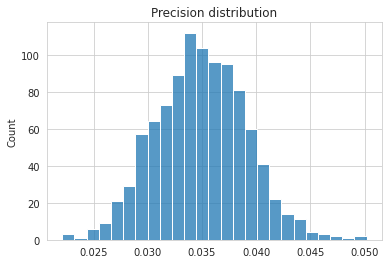

In [44]:
N = 1000
precisions = np.zeros(N)
for i in range(N):
    precisions[i] = comb.sample(n=1000)['precision'].mean()

print(pd.Series(precisions).describe())
sns.histplot(precisions)
plt.title('Precision distribution');

# validation set

In [29]:
model = CatBoostRanker().load_model(fname=str(data_root / '2020-09-08' / 'pair_logit.model'))
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')

c = pd.read_parquet(data_root / 'clean' / 'customers.parquet')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])

df = df.merge(c[['customer_id', 'age_group']], on='customer_id')
train = filter_data(df, '2020-09-08', '2020-09-15')
top12_age_pred = age_chart(train)

In [42]:
rec_df = pd.read_parquet(data_root / '2020-09-15' / 'candidates.parquet')

In [45]:
# CB
rec_df = pd.read_parquet(data_root / '2020-09-15' / 'X.parquet')
pred_df = rf.rank_predictions(rec_df, model)

In [ ]:
test = filter_data(df, '2020-09-16', '2020-09-22')
results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()
results = results.merge(c[['customer_id', 'age_group']], on='customer_id')

In [46]:
comb = results.merge(pred_df, on='customer_id', how='left')
comb = comb.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
comb['prediction'] = comb['candidates'].combine_first(comb['naive_pred'])

comb = compute_precision(comb)
comb['precision'].mean()

0.03195323032102248

In [47]:
comb[comb['candidates'].notna()]['precision'].mean()

0.03413591794461487

# submission

In [ ]:
model = CatBoostRanker().load_model(fname=str(data_root / '2020-09-08' / 'pair_logit.model'))

In [29]:
model.feature_names_

['score',
 'article_totals',
 'age',
 'product_type_name_clean',
 'colour_group_name_clean',
 'department_name_clean',
 'section_name_clean',
 'total_cust',
 'item_age',
 'monday_item',
 'avg_per_customer',
 'daily_sales',
 'avg_price',
 'avg_age',
 'product_totals',
 'segment',
 'method']

In [3]:
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')

c = pd.read_parquet(data_root / 'clean' / 'customers.parquet')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])

df = df.merge(c[['customer_id', 'age_group']], on='customer_id')
train = filter_data(df, '2020-09-15', '2020-09-22')

In [4]:
rec_df = pd.read_parquet(data_root / '2020-09-22' / 'X.parquet')
# pred_df = rf.rank_predictions(rec_df, model)

In [5]:
rec_df.head()

,score,customer_id,article_id,method,product_code,article_totals,product_totals,age,product_type_name,colour_group_name,...,item_age,daily_sales,monday_item,avg_per_customer,segment,total_items,product_type_name_clean,colour_group_name_clean,department_name_clean,section_name_clean
0,0.003916,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0902407003,als,902407,NaN,NaN,28.0,Hoodie,Orange,...,0.043478,20.869565,1,1.105991,old,11,0.111111,0.111111,0.111111,0.111111
1,0.003278,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0918200001,als,918200,NaN,NaN,28.0,Blouse,Black,...,0.083333,12.166667,0,1.226891,old,11,0.166667,0.500000,0.111111,0.388889
2,0.003110,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0889652001,als,889652,NaN,NaN,28.0,Trousers,Black,...,0.032258,12.354839,0,1.293919,old,11,0.222222,0.500000,0.166667,0.388889
3,0.002861,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0914999001,als,914999,NaN,NaN,28.0,Top,Black,...,0.166667,14.400000,0,1.074627,old,11,0.222222,0.500000,0.111111,0.111111
4,0.002802,00401a367c5ac085cb9d4b77c56f3edcabf25153615db9...,0903352001,als,903352,NaN,NaN,28.0,Jacket,Black,...,0.166667,15.750000,0,1.166667,old,11,0.111111,0.500000,0.111111,0.111111


In [6]:
rec_df['rank'] = rec_df.groupby('customer_id')['score'].rank(ascending=False, method='first')

relevant_items = rec_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
pred_df = relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))

In [7]:
submission = pd.read_csv('/data/sstamenov/kaggle-data/sample_submission.csv').drop(columns=['prediction'])
submission = submission.merge(c[['customer_id', 'age_group']], on='customer_id', how='left')
submission.head()

,customer_id,age_group
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"(40, 50]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"(21, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"(21, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"(50, 60]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"(50, 60]"


In [8]:
top12_age_pred = age_chart(train)
submission = submission.merge(pred_df, on='customer_id', how='left')
submission = submission.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [9]:
submission.head()

,customer_id,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0568601043, 0779781015, 0568601006, 085885600...","[0751471001, 0923758001, 0924243001, 092424300...","[0568601043, 0779781015, 0568601006, 085885600..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0739590027, 0590928001, 0882759003, 035148403...","[0924243001, 0918522001, 0924243002, 091552900...","[0739590027, 0590928001, 0882759003, 035148403..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0599580038, 0685813001, 0768931002, 073959002...","[0924243001, 0918522001, 0924243002, 091552900...","[0599580038, 0685813001, 0768931002, 073959002..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...","[0924243001, 0928206001, 0930380001, 092424300..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0730683050, 0791587015, 089615200...","[0924243001, 0928206001, 0930380001, 092424300...","[0896152002, 0730683050, 0791587015, 089615200..."


In [10]:
submission.shape[0]

1371980

In [11]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [12]:
submission.head()

,customer_id,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0568601043, 0779781015, 0568601006, 085885600...","[0751471001, 0923758001, 0924243001, 092424300...",0568601043 0779781015 0568601006 0858856005 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0739590027, 0590928001, 0882759003, 035148403...","[0924243001, 0918522001, 0924243002, 091552900...",0739590027 0590928001 0882759003 0351484039 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0599580038, 0685813001, 0768931002, 073959002...","[0924243001, 0918522001, 0924243002, 091552900...",0599580038 0685813001 0768931002 0739590027 08...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...",0924243001 0928206001 0930380001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0730683050, 0791587015, 089615200...","[0924243001, 0928206001, 0930380001, 092424300...",0896152002 0730683050 0791587015 0896152001 07...


In [13]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/2020-09-22/submission.csv', index=False)